# AIN 214 - PA5 - 2023 on Clustering

This homework aims to deepen your understanding of clustering algorithms and introduce the concept of dimensionality reduction using Principal Component Analysis (PCA). You will use K-Means and Agglomerative Clustering, and explore the impact of PCA on these clustering techniques.



# Student Info
## Name Surname: Özge Bülbül
## Student ID: 2220765008


## Dataset

We will use the Mall Customer Segmentation Data from Kaggle. The dataset is added to the homework folder - also accessible at [here](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/).
 

## 1. Data Cleaning

* **Objective**: Prepare your dataset for analysis.
* **Tasks**: Handle missing values, encode categorical features, handle outliers.

The steps for data cleaning may vary. I do not expect you to use a spefisific algorithm to handle outliers for example. But **show your work!**


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv('Mall_Customers.csv')
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [33]:
df.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Above, I checked  if there are any null values and there weren't any.

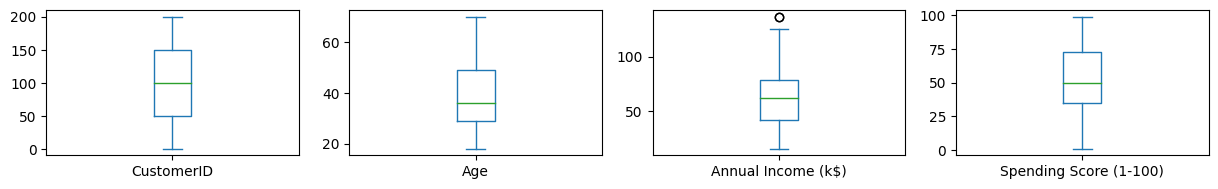

In [34]:
df.plot(kind="box",subplots=True,layout=(9,4),figsize=(15,20))
plt.show()

I visualized the outliers with boxplots and the only visible outliers are among the feature 'annual income'. However, obviously this is not enough to decide on outliers. I will perform IQR outlier detection with my outlier_remover function below. This function removes the values that are outside the interquartile range limits. 

In [35]:
def outlier_remover(df, columns):
    outlier_removed_df = df.copy()
    for column in columns:
        data = outlier_removed_df[column]
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = (data < lower_bound) | (data > upper_bound)
        outlier_removed_df.loc[outliers, column] = None

    return outlier_removed_df

In [36]:
numerical_columns = df.select_dtypes(include=np.number).columns
df_no_outliers = outlier_remover(df, numerical_columns)
df_no_outliers

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1.0,Male,19.0,15.0,39.0
1,2.0,Male,21.0,15.0,81.0
2,3.0,Female,20.0,16.0,6.0
3,4.0,Female,23.0,16.0,77.0
4,5.0,Female,31.0,17.0,40.0
...,...,...,...,...,...
195,196.0,Female,35.0,120.0,79.0
196,197.0,Female,45.0,126.0,28.0
197,198.0,Male,32.0,126.0,74.0
198,199.0,Male,32.0,NaN,18.0


In [37]:
df_no_outliers.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        2
Spending Score (1-100)    0
dtype: int64

There are only two outliers. Since that's only 1% of the whole data, I found it more sensible to remove them instead of applying imputation techniques. 

In [38]:
df_no_outliers.dropna(inplace=True)

In [39]:
df_no_outliers.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Here, I binary encoded the gender feature so that Male: 1 and Female: 0. Then, I dropped the customer id and unencoded gender features. I dropped customer id because it is a unique value that won't be helpful during the clustering process.

In [40]:
df_no_outliers["Gender Encoded (Female:0)"] = df_no_outliers['Gender'].map({'Male': 1, 'Female': 0})
columnsToDrop = ['Gender','CustomerID']
df_no_outliers = df_no_outliers.drop(columns=columnsToDrop)
column_order = ['Gender Encoded (Female:0)', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
df_no_outliers = df_no_outliers[column_order]

In [41]:
df_no_outliers

,Gender Encoded (Female:0),Age,Annual Income (k$),Spending Score (1-100)
0,1,19.0,15.0,39.0
1,1,21.0,15.0,81.0
2,0,20.0,16.0,6.0
3,0,23.0,16.0,77.0
4,0,31.0,17.0,40.0
...,...,...,...,...
193,0,38.0,113.0,91.0
194,0,47.0,120.0,16.0
195,0,35.0,120.0,79.0
196,0,45.0,126.0,28.0


## 2. Data Preprocessing

* **Objective**: Transform raw data into a format suitable for ML algorithms: PCA, and clustering, such as normalization.

In [42]:
from sklearn.preprocessing import MinMaxScaler

In [43]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_no_outliers)
normalized_df = pd.DataFrame(normalized_data, columns=df_no_outliers.columns)
normalized_df

,Gender Encoded (Female:0),Age,Annual Income (k$),Spending Score (1-100)
0,1.0,0.019231,0.000000,0.387755
1,1.0,0.057692,0.000000,0.816327
2,0.0,0.038462,0.009009,0.051020
3,0.0,0.096154,0.009009,0.775510
4,0.0,0.250000,0.018018,0.397959
...,...,...,...,...
193,0.0,0.384615,0.882883,0.918367
194,0.0,0.557692,0.945946,0.153061
195,0.0,0.326923,0.945946,0.795918
196,0.0,0.519231,1.000000,0.275510


In order to transform our data into a format suitable for PCA, and clustering, I applied min-max normalization to the data. I put all values in between 0 and 1, 0 representing the lowest and 1 the highest.

## 3. Dimensionality Reduction

### What is Dimensionality Reduction and Why is it Used?
Dimensionality reduction is the process of reducing the number of random variables under consideration by obtaining a set of principal variables. It is an attempt to reduce the complexity of the task as an attempt to remove the curse of dimensionality - also for visualization purposes.

### 3.1. Principal Component Analysis (PCA)
PCA is a technique that transforms original correlated features into new uncorrelated features (principal components) based on variance.
**Process:**
* **Linear Combinations of Features:** PCA begins by creating linear combinations of the existing features in the dataset.
* **First Principal Component:** The first principal component (PC1) is the linear combination that captures the highest variance in the dataset. Mathematically, this is the direction in which the data varies the most.
* **Subsequent Principal Components:** Each following principal component is the linear combination of features that captures the highest variance possible while being orthogonal (perpendicular) to all previously determined principal components. This ensures that each new principal component adds unique information.
* **Covariance Matrix and Eigenvectors:** The process of finding these principal components corresponds to computing the eigenvectors of the covariance matrix of the data. The covariance matrix encapsulates how each pair of variables in the dataset co-varies.
* **Eigenvalues:** The eigenvalues associated with each eigenvector (principal component) indicate the amount of variance that the principal component explains. Larger eigenvalues mean more variance explained.





### 3.2. Apply PCA
* Normalize the data
* Apply PCA to the normalized data using scikit-learn
* Visualize the data with the first two principal components (PC) as the axes. Do you see any clusters?
* Components selection: Visualize the variance explained by each PC. Then choose the number of components that explain the data sufficiently enough.

**Simply use the PCA from sklearn library**

In [44]:
from sklearn.decomposition import PCA

I have 4 features, so I will get 3 components in order to reduce dimensionality.

In [45]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(normalized_df[['Gender Encoded (Female:0)', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
df_pca = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2', 'PCA3'])

Below, I visualized the first two principle components as axes. I see two clusters.

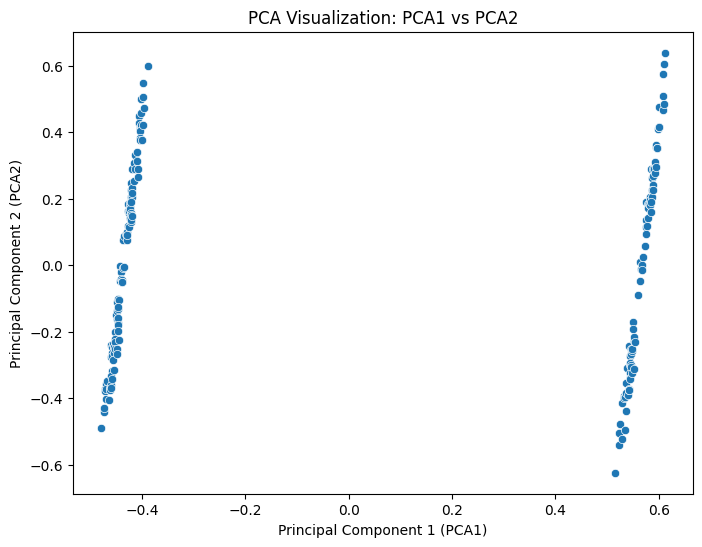

In [46]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', data=df_pca)
plt.title('PCA Visualization: PCA1 vs PCA2')
plt.xlabel('Principal Component 1 (PCA1)')
plt.ylabel('Principal Component 2 (PCA2)')
plt.show()

Below, I calculated and visualized the individual and cumulative experienced variances of the PCA's. 

In [47]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

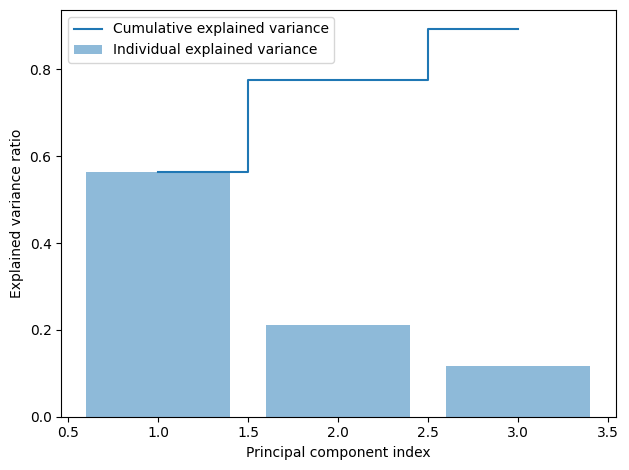

In [48]:
plt.bar(range( 1,len(explained_variance_ratio)+1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(cumulative_explained_variance)+1), cumulative_explained_variance, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

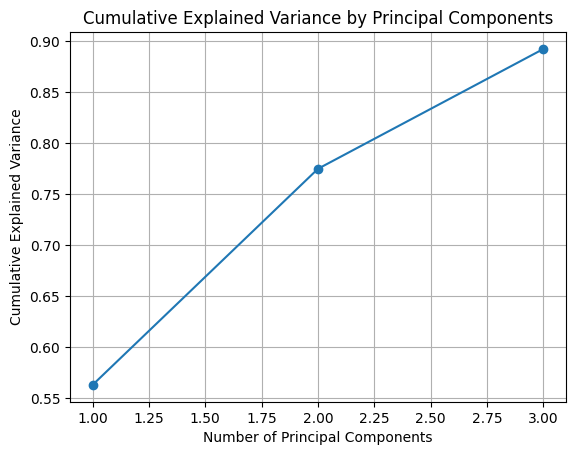

In [49]:
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

After 2 components, increase in cumulative explained variance gets diminished. Therefore, I chose 2 components.

## 4. Clustering on the Original Dataset

### 4.1. K-Means Clustering on the Original Dataset

Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

In [50]:
from sklearn.cluster import KMeans

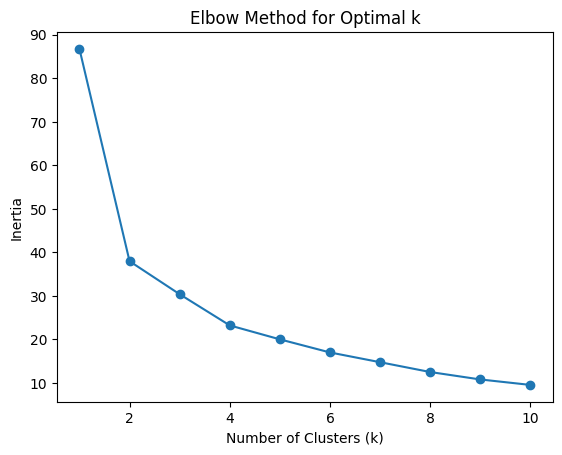

In [51]:
features_for_clustering = ['Gender Encoded (Female:0)', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
inertia_values = []

k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(normalized_df[features_for_clustering])
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

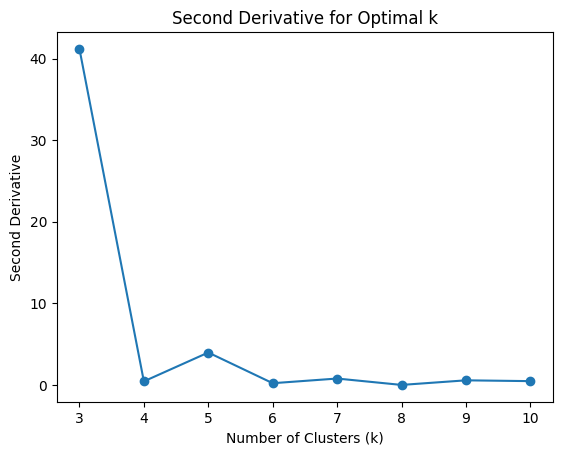

In [52]:
features_for_clustering = ['Gender Encoded (Female:0)', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
inertia_values = []

k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(normalized_df[features_for_clustering])
    inertia_values.append(kmeans.inertia_)

# Calculate the second derivative
inertia_values_np = np.array(inertia_values)
second_derivative = np.diff(np.diff(inertia_values_np))

# Plot the second derivative
plt.plot(k_values[2:], second_derivative, marker='o')
plt.title('Second Derivative for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Second Derivative')
plt.show()

In this plot, the point where the second derivative decreases (where the rate of decrease in inertia slows down) gives us the optimal k. From the inertia and second derivative graphs, I chose 5 as the number of clusters.

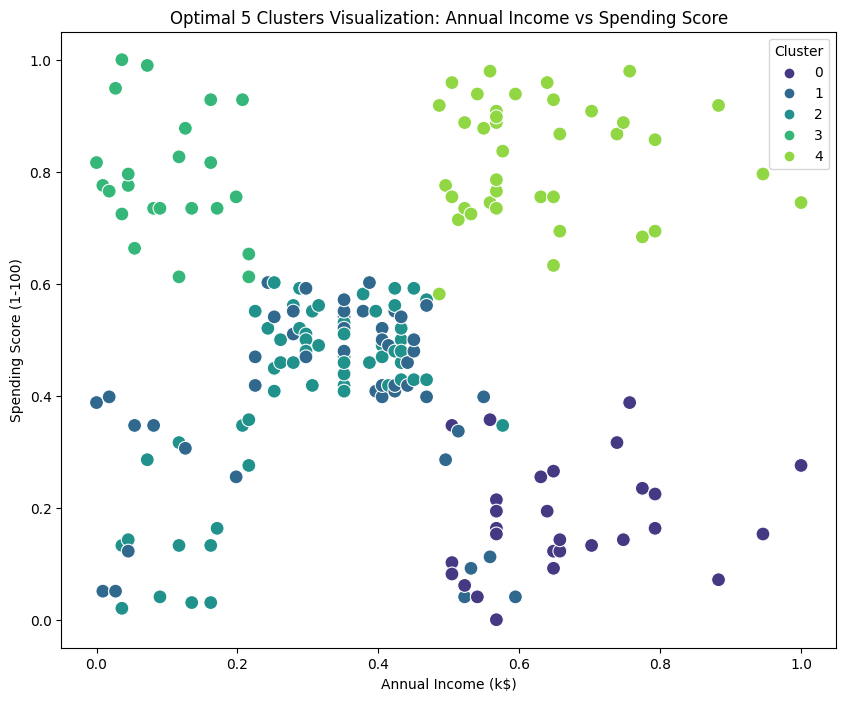

In [60]:
optimal_k = 5
n_init_value = 10

kmeans = KMeans(n_clusters=optimal_k, n_init=n_init_value, random_state=42)
normalized_df['OptimalCluster'] = kmeans.fit_predict(normalized_df[features_for_clustering])

normalized_df['OptimalCluster'] = normalized_df['OptimalCluster'].astype('category')

plt.figure(figsize=(10, 8))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='OptimalCluster', data=normalized_df, palette='viridis', s=100)
plt.title(f'Optimal {optimal_k} Clusters Visualization: Annual Income vs Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.show()

### 4.2. Hierarchical Agglomerative Clustering (HAC) on the Original Dataset

Apply HAC on the dataset, visualize the dendogram. Then, comment on whether the dendogram agrees with the clusters obtained by K-Means. Try with 2 different linkage methods.

In [54]:
from scipy.cluster.hierarchy import dendrogram, linkage

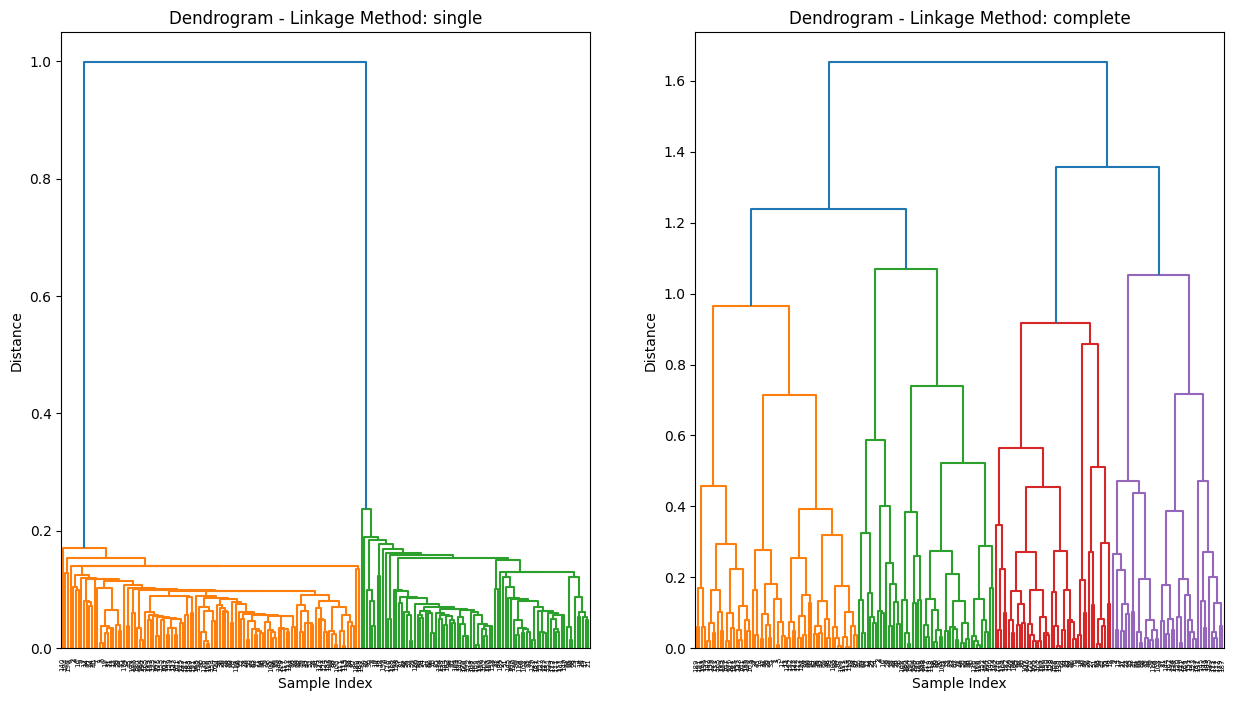

In [55]:
linkage_methods = ['single', 'complete']
plt.figure(figsize=(15, 8))

for i, linkage_method in enumerate(linkage_methods, 1):
    plt.subplot(1, 2, i)
    Z = linkage(df_pca, method=linkage_method)
    dendrogram(Z, labels=df_pca.index, orientation='top')
    plt.title(f'Dendrogram - Linkage Method: {linkage_method}')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')

plt.show()

I tried single and complete linkage methods. Single linkage shows 2 and complete shows 4 clusters. Therefore, complete linkage is closer to k-means in terms of number of cluster because there are 5 clusters in k-means.

## 5. K-means Clustering with PCA

Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

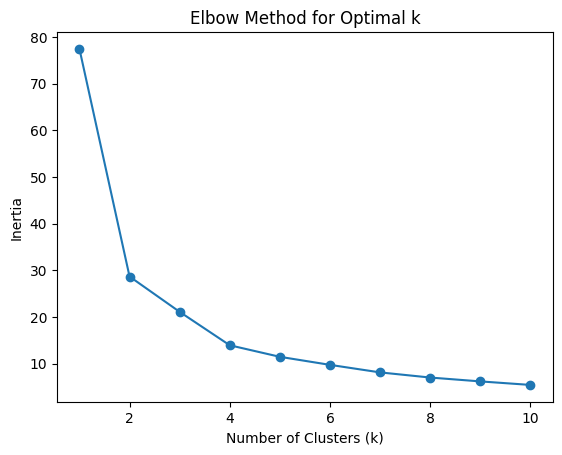

In [56]:
features_for_clustering = ['PCA1', 'PCA2', 'PCA3']
inertia_values = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca[features_for_clustering])
    inertia_values.append(kmeans.inertia_)

plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

I chose optimal k as 4. Below, I visualized the four clusters.

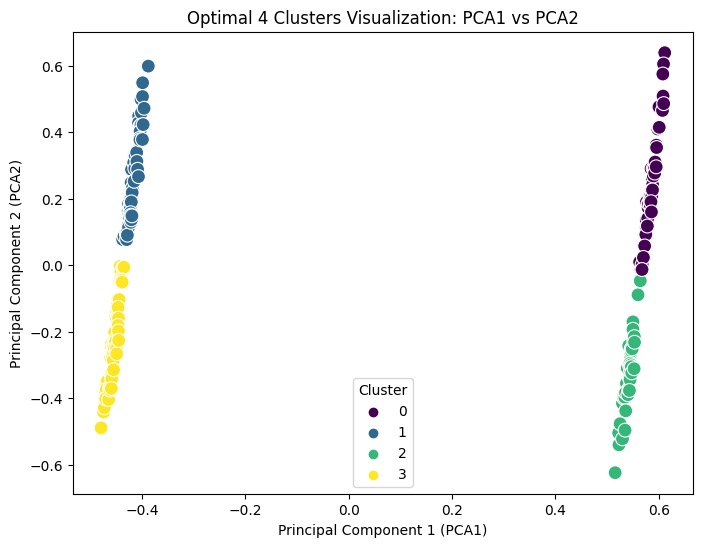

In [57]:
optimal_k = 4
n_init_value = 10 

kmeans = KMeans(n_clusters=optimal_k, n_init=n_init_value, random_state=42)
df_pca['OptimalCluster'] = kmeans.fit_predict(df_pca[features_for_clustering])

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='OptimalCluster', data=df_pca, palette='viridis', s=100)
plt.title(f'Optimal {optimal_k} Clusters Visualization: PCA1 vs PCA2')
plt.xlabel('Principal Component 1 (PCA1)')
plt.ylabel('Principal Component 2 (PCA2)')
plt.legend(title='Cluster')
plt.show()

## 6. Evaluate the Clustering Results

* Evaluate and compare the clustering results obtained in 4.1 and 5 (k means with and without PCA) using the Silhouette Coefficients.
* Which is better?

In [58]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [63]:
features_for_clustering = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

optimal_k_without_pca = 5
n_init_value = 10 

kmeans_without_pca = KMeans(n_clusters=optimal_k_without_pca, random_state=42, n_init=n_init_value)
normalized_df['OptimalClusterWithoutPCA'] = kmeans_without_pca.fit_predict(normalized_df[features_for_clustering])

optimal_k_with_pca = 4
pca = PCA(n_components=2)
df_pca = pca.fit_transform(normalized_df[features_for_clustering])
kmeans_with_pca = KMeans(n_clusters=optimal_k_with_pca, random_state=42, n_init=n_init_value)
normalized_df['OptimalClusterWithPCA'] = kmeans_with_pca.fit_predict(df_pca)

silhouette_score_without_pca = silhouette_score(normalized_df[features_for_clustering], normalized_df['OptimalClusterWithoutPCA'])
silhouette_score_with_pca = silhouette_score(df_pca, normalized_df['OptimalClusterWithPCA'])

print(f"Silhouette Coefficient without PCA: {silhouette_score_without_pca}")
print(f"Silhouette Coefficient with PCA: {silhouette_score_with_pca}")

Silhouette Coefficient without PCA: 0.4104296224237385
Silhouette Coefficient with PCA: 0.3879146466639857


The Silhouette Coefficient is a measure of how well-separated clusters are in a clustering result. It ranges from -1 to 1, where a higher value indicates better-defined clusters.<br><br>

In this case, without PCA is slightly better because it has a higher silhouette coefficient value. However, it is crucial to remember that while a higher silhouette coefficient is generally desirable, it should not be the sole criterion for evaluating clustering results. 